In [ ]:
import pandas as pd
import nannyml as nml
reference, analysis, analysis_targets = nml.datasets.load_modified_california_housing_dataset()
reference.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,timestamp,period,clf_target,y_pred_proba,y_pred,identifier
0,9.8413,32.0,7.170040,1.014845,4353.0,2.937247,34.22,-118.19,2020-10-01 00:00:00,reference,1,0.99,1,0
1,8.3695,37.0,7.458746,1.062706,941.0,3.105611,34.22,-118.21,2020-10-01 01:00:00,reference,1,1.00,1,1
2,8.7200,44.0,6.163180,1.046025,668.0,2.794979,34.20,-118.18,2020-10-01 02:00:00,reference,1,1.00,1,2


In [ ]:
print(reference.head(3).to_markdown(tablefmt="grid"))

+----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------------+-----------+--------------+----------------+----------+--------------+
|    |   MedInc |   HouseAge |   AveRooms |   AveBedrms |   Population |   AveOccup |   Latitude |   Longitude | timestamp           | period    |   clf_target |   y_pred_proba |   y_pred |   identifier |
+====+==========+============+============+=============+==============+============+============+=============+=====================+===========+==============+================+==========+==============+
|  0 |   9.8413 |         32 |    7.17004 |     1.01484 |         4353 |    2.93725 |      34.22 |     -118.19 | 2020-10-01 00:00:00 | reference |            1 |           0.99 |        1 |            0 |
+----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------------+-----------+--------------+----------------+--

In [ ]:
# fit performance estimator and estimate for combined reference and analysis
cbpe = nml.CBPE(
    y_pred='y_pred',
    y_pred_proba='y_pred_proba',
    y_true='clf_target',
    timestamp_column_name='timestamp',
    problem_type='classification_binary',
    chunk_period='M',
    metrics=['roc_auc'])
cbpe.fit(reference_data=reference)
est_perf = cbpe.estimate(pd.concat([reference, analysis]))

In [ ]:
est_perf_data = est_perf.to_df()
est_perf.data[('chunk', 'end_index')] - est_perf.data[('chunk', 'start_index')]

0     743
1     719
2     743
3     743
4     671
5     743
6     719
7     743
8     743
9     719
10    743
11    743
12    671
13    743
14    719
15    743
16    719
17    743
18    743
19    719
20    743
21    719
22    743
23    743
24    671
25    743
26    719
27    215
dtype: int64

In [ ]:
est_perf.data = est_perf.data[:-1].copy()
est_perf.data.tail(2)

chunk                                               \
        key chunk_index start_index end_index start_date   
25  2022-03          17       12384     13127 2022-03-01   
26  2022-04          18       13128     13847 2022-04-01   

                                                  roc_auc                     \
                        end_date    period sampling_error realized     value   
25 2022-03-31 23:59:59.999999999  analysis       0.007781      NaN  0.829077   
26 2022-04-30 23:59:59.999999999  analysis       0.007910      NaN  0.910661   

                                                                        \
   upper_confidence_boundary lower_confidence_boundary upper_threshold   
25                  0.852420                  0.805734             1.0   
26                  0.934389                  0.886932             1.0   

                           
   lower_threshold  alert  
25        0.708336  False  
26        0.708336  False

In [ ]:
print(est_perf.data.tail(2).to_markdown(tablefmt="grid"))

+----+--------------------+----------------------------+----------------------------+--------------------------+---------------------------+-------------------------------+-----------------------+---------------------------------+---------------------------+------------------------+--------------------------------------------+--------------------------------------------+----------------------------------+----------------------------------+------------------------+
|    | ('chunk', 'key')   |   ('chunk', 'chunk_index') |   ('chunk', 'start_index') |   ('chunk', 'end_index') | ('chunk', 'start_date')   | ('chunk', 'end_date')         | ('chunk', 'period')   |   ('roc_auc', 'sampling_error') |   ('roc_auc', 'realized') |   ('roc_auc', 'value') |   ('roc_auc', 'upper_confidence_boundary') |   ('roc_auc', 'lower_confidence_boundary') |   ('roc_auc', 'upper_threshold') |   ('roc_auc', 'lower_threshold') | ('roc_auc', 'alert')   |
+====+====================+============================+======

In [ ]:
fig = est_perf.plot(kind='performance', metric='roc_auc')
fig.show()

In [ ]:
fig.write_image(file=f"../_static/example_california_performance.svg")

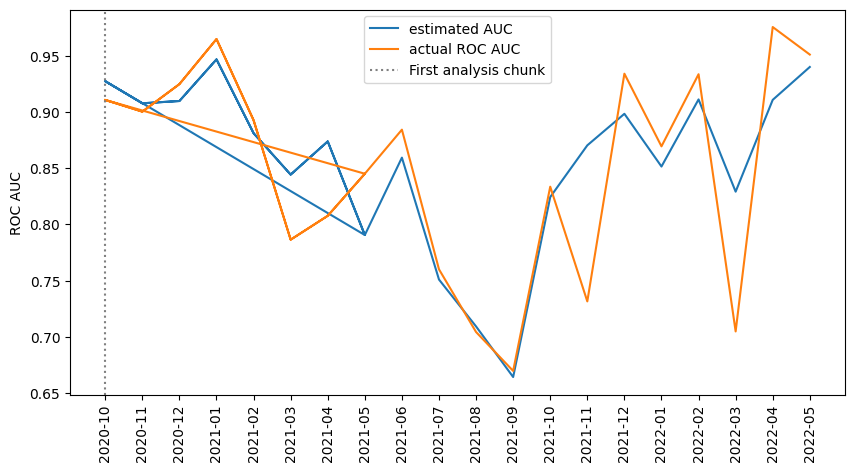

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_full = pd.merge(analysis, analysis_targets, on = 'identifier')
df_all = pd.concat([reference, analysis_full]).reset_index(drop=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'y_pred_proba'
actual_performance = []
for idx in est_perf_data.index:
    start_date, end_date = est_perf_data.loc[idx, ('chunk', 'start_date')], est_perf_data.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    est_perf_data.loc[idx, ('roc_auc', 'realized')] = actual_perf
# plot
first_analysis = est_perf_data[('chunk', 'key')].values[0]
plt.figure(figsize=(10,5))
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'value')], label='estimated AUC')
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'realized')], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

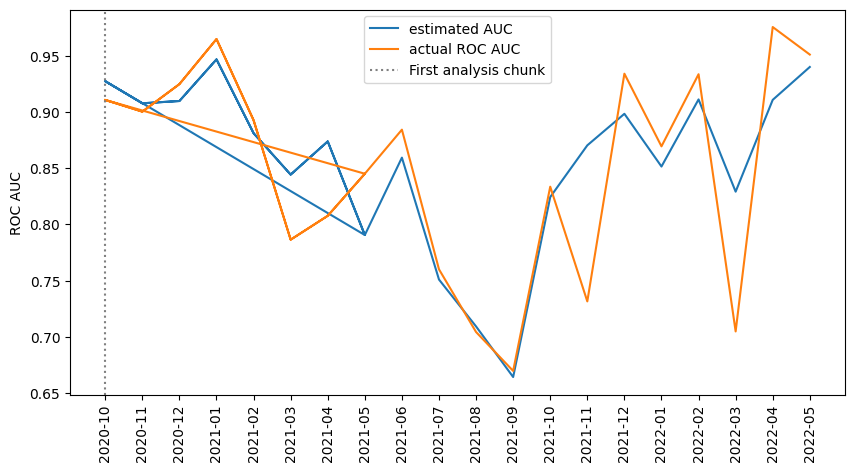

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_full = pd.merge(analysis, analysis_targets, on = 'identifier')
df_all = pd.concat([reference, analysis_full]).reset_index(drop=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'y_pred_proba'
actual_performance = []
for idx in est_perf_data.index:
    start_date, end_date = est_perf_data.loc[idx, ('chunk', 'start_date')], est_perf_data.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    est_perf_data.loc[idx, ('roc_auc', 'realized')] = actual_perf
# plot
first_analysis = est_perf_data[('chunk', 'key')].values[0]
plt.figure(figsize=(10,5))
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'value')], label='estimated AUC')
plt.plot(est_perf_data[('chunk', 'key')], est_perf_data[('roc_auc', 'realized')], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.savefig("../_static/example_california_performance_estimation_tmp.svg")

In [ ]:
feature_column_names = [col for col in reference if col not in ['y_pred', 'y_pred_proba', 'clf_target', 'timestamp', 'period', 'identifier']]
univariate_calculator = nml.UnivariateDriftCalculator(column_names=feature_column_names,
                                                      timestamp_column_name='timestamp',
                                                      chunk_period='M').fit(reference_data=reference)
univariate_results = univariate_calculator.calculate(analysis)
nml.Ranker.by('alert_count').rank(univariate_results)

,column_name,number_of_alerts,rank
0,Longitude,12,1
1,Latitude,12,2
2,HouseAge,12,3
3,AveOccup,12,4
4,MedInc,11,5
5,AveRooms,11,6
6,Population,8,7
7,AveBedrms,8,8


In [ ]:
ranked = nml.Ranker.by('alert_count').rank(univariate_results)
print(ranked.to_markdown(tablefmt="grid"))

+----+---------------+--------------------+--------+
|    | column_name   |   number_of_alerts |   rank |
+====+===============+====================+========+
|  0 | Longitude     |                 12 |      1 |
+----+---------------+--------------------+--------+
|  1 | Latitude      |                 12 |      2 |
+----+---------------+--------------------+--------+
|  2 | HouseAge      |                 12 |      3 |
+----+---------------+--------------------+--------+
|  3 | AveOccup      |                 12 |      4 |
+----+---------------+--------------------+--------+
|  4 | MedInc        |                 11 |      5 |
+----+---------------+--------------------+--------+
|  5 | AveRooms      |                 11 |      6 |
+----+---------------+--------------------+--------+
|  6 | Population    |                  8 |      7 |
+----+---------------+--------------------+--------+
|  7 | AveBedrms     |                  8 |      8 |
+----+---------------+--------------------+---

In [ ]:
# get columns with d statistics only
# # # print(result.data.loc[:, (non_chunk, slice(None), 'alert')])
univariate_results.to_df().loc[:, (slice(None), 'kolmogorov_smirnov', 'value')].mean().sort_values(ascending=False)

Longitude   kolmogorov_smirnov  value    0.712709
Latitude    kolmogorov_smirnov  value    0.672904
HouseAge    kolmogorov_smirnov  value    0.201638
MedInc      kolmogorov_smirnov  value    0.154952
AveOccup    kolmogorov_smirnov  value    0.143890
AveRooms    kolmogorov_smirnov  value    0.129277
AveBedrms   kolmogorov_smirnov  value    0.089140
Population  kolmogorov_smirnov  value    0.073562
dtype: float64

In [ ]:
print(univariate_results.to_df().loc[:, (slice(None), 'kolmogorov_smirnov', 'value')].mean().sort_values(ascending=False).to_markdown(tablefmt="grid"))

+-----------------------------------------------+-----------+
|                                               |         0 |
+===============================================+===========+
| ('Longitude', 'kolmogorov_smirnov', 'value')  | 0.712709  |
+-----------------------------------------------+-----------+
| ('Latitude', 'kolmogorov_smirnov', 'value')   | 0.672904  |
+-----------------------------------------------+-----------+
| ('HouseAge', 'kolmogorov_smirnov', 'value')   | 0.201638  |
+-----------------------------------------------+-----------+
| ('MedInc', 'kolmogorov_smirnov', 'value')     | 0.154952  |
+-----------------------------------------------+-----------+
| ('AveOccup', 'kolmogorov_smirnov', 'value')   | 0.14389   |
+-----------------------------------------------+-----------+
| ('AveRooms', 'kolmogorov_smirnov', 'value')   | 0.129277  |
+-----------------------------------------------+-----------+
| ('AveBedrms', 'kolmogorov_smirnov', 'value')  | 0.0891403 |
+-------

In [ ]:
for col in ['Longitude', 'Latitude']:
    fig = univariate_results.plot(
        kind='distribution',
        method='kolmogorov_smirnov',
        column_name=col)
    fig.show()

In [ ]:
for col in ['Longitude', 'Latitude']:
    fig = univariate_results.plot(
        kind='distribution',
        method='kolmogorov_smirnov',
        column_name=col)
    fig.write_image(f"../_static/example_california_performance_distribution_{col}.svg")

Text(0, 0.5, 'Longitude')

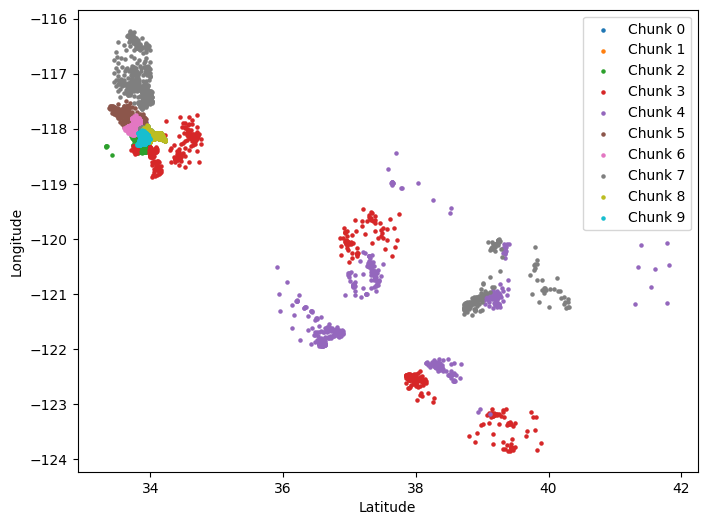

In [ ]:
analysis_res = est_perf.data
plt.figure(figsize=(8,6))
for idx in analysis_res.index[:10]:
    start_date, end_date = analysis_res.loc[idx, ('chunk', 'start_date')], analysis_res.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    plt.scatter(sub['Latitude'], sub['Longitude'], s=5, label="Chunk {}".format(str(idx)))

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')

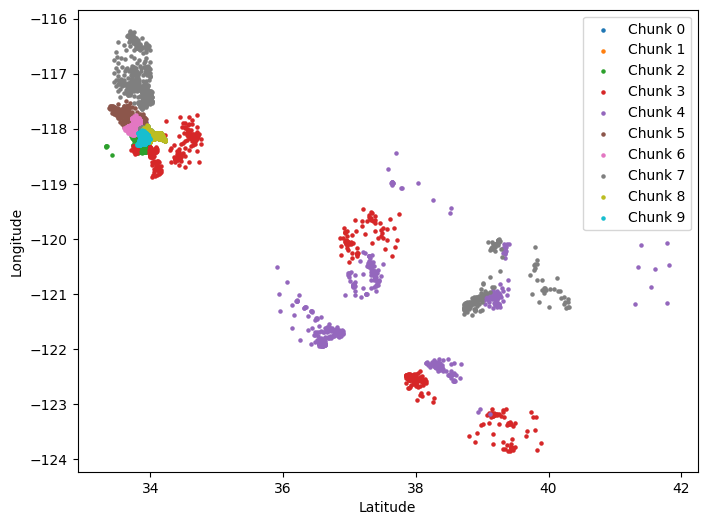

In [ ]:
analysis_res = est_perf.data
plt.figure(figsize=(8,6))
for idx in analysis_res.index[:10]:
    start_date, end_date = analysis_res.loc[idx, ('chunk', 'start_date')], analysis_res.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    plt.scatter(sub['Latitude'], sub['Longitude'], s=5, label="Chunk {}".format(str(idx)))

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.savefig("../_static/example_california_latitude_longitude_scatter.svg")
